In [1]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import model.util as model_util
import model.profile_models as profile_models
import model.train_profile_model as train_profile_model
import model.binary_models as binary_models
import model.train_binary_model as train_binary_model
import feature.util as feature_util
import feature.make_profile_dataset as make_profile_dataset
import feature.make_binary_dataset as make_binary_dataset
import plot.viz_sequence as viz_sequence
import pandas as pd
import numpy as np
import torch
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available
import matplotlib.pyplot as plt
import json
import sknetwork as skn

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


### Define paths for the model and data of interest

In [ ]:
model_type = "binary"

In [ ]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
input_length = 1000 if model_type == "binary" else 1346

In [ ]:
files_spec_path = "/users/amtseng/att_priors/data/processed/ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type
num_tasks = 4
model_class = binary_models.BinaryPredictor if model_type == "binary" else profile_models.ProfilePredictorWithControls
use_controls = True
model_path = "/users/amtseng/att_priors/models/trained_models/%s_models/SPI1/1/model_ckpt_epoch_10.pt" % model_type
chrom_set = ["chr1"]

In [ ]:
# Extract the file specs
with open(files_spec_path, "r") as f:
    files_spec = json.load(f)
if model_type == "binary":
    labels_hdf5 = files_spec["labels_hdf5"]
    bin_labels_npy = files_spec["bin_labels_npy"]
else:
    peaks_bed = files_spec["peak_beds"][0]  # First peaks BED, arbitrarily
    profile_hdf5 = files_spec["profile_hdf5"]

In [ ]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = model_util.restore_model(model_class, model_path)
model.eval()
model = model.to(device) 

### Data preparation
Use classes from `make_profile_dataset` to prepare peak inputs

In [ ]:
# Maps coordinates to 1-hot encoded sequence
coords_to_seq = feature_util.CoordsToSeq(reference_fasta, center_size_to_use=input_length)

if model_type == "binary":
        # Maps bin index to profiles
        bins_to_vals = make_binary_dataset.BinsToVals(labels_hdf5)

    # Maps many bin indices to coordinates, inputs sequences, and output values for the network
    def bin_inds_to_network_inputs(bin_inds):
        coords, outout_vals = bins_to_vals(bin_inds) 
        input_seqs = coords_to_seq(coords)
        return coords, input_seqs, outout_vals
    
    # Import set of all labels
    labels_array = np.load(bin_labels_npy, allow_pickle=True)

    # Get set of positive and negative bin indices
    chrom_mask = np.isin(labels_array[:, 0], chrom_set)
    pos_examples = np.where(chrom_mask & (labels_array[:, 1] == 1))[0]
else:
    # Maps coordinates to profiles
    coords_to_vals = make_profile_dataset.CoordsToVals(profile_hdf5, profile_length)

    # Maps many coordinates to inputs sequences and profiles for the network
    def coords_to_network_inputs(coords):
        input_seq = coords_to_seq(coords)
        profs = coords_to_vals(coords)
        return input_seq, np.swapaxes(profs, 1, 2)
    # Import set of positive peaks
    pos_coords_table = pd.read_csv(peaks_bed, sep="\t", header=None, compression="gzip")
    # Filter for only the desired chromosomes
    pos_coords_table = pos_coords_table[pos_coords_table[0].isin(chrom_set)]
    pos_examples = pos_coords_table.values[:, :3]

### Predicting outputs

In [ ]:
def get_input_grads(model, model_type, coords_or_bin_inds):
    """
    Fetches the necessary data from the given coordinates or bin indices
    and runs it through a profile or binary model. Returns the input
    gradients and the input sequences as NumPy arrays.
    """
    if model_type == "binary":
        coords, input_seqs_np, output_vals_np = bin_inds_to_network_inputs(coords_or_bin_inds)
        output_vals = model_util.place_tensor(torch.tensor(output_vals_np)).float()
    else:
        input_seqs_np, profiles = coords_to_network_inputs(coords_or_bin_inds)
        profiles = model_util.place_tensor(torch.tensor(profiles)).float()
        if use_controls:
            true_profs = profiles[:, :num_tasks, :, :]
            cont_profs = profiles[:, num_tasks:, :, :]
        else:
            true_profs, cont_profs = profiles, None
    input_seqs = model_util.place_tensor(torch.tensor(input_seqs_np)).float()

    model.zero_grad()
    
    # Run through the model
    input_seqs.requires_grad = True  # Set gradient required
    if model_type == "binary":
        output = model(input_seqs)
    else:
        output, _ = model(input_seqs, cont_profs)
    
    # Compute input gradients
    input_grads, = torch.autograd.grad(
        output, input_seqs,
        grad_outputs=model_util.place_tensor(torch.ones(output.size())),
        retain_graph=True, create_graph=True
    )
    input_grads_np = input_grads.detach().cpu().numpy()
    
    return input_grads_np, input_seqs_np

### Computing the input gradients
From the model and the specified peaks, compute input gradients for all peaks

In [ ]:
# Compute the gradients for all positive examples specified
batch_size = 64
num_batches = int(np.ceil(len(pos_examples) / batch_size))

output_shape = (len(pos_examples), input_length, 4)
input_seqs, input_grads = np.empty(output_shape), np.empty(output_shape)

for i in tqdm.notebook.trange(num_batches):
    coords_or_bin_inds = pos_examples[(i * batch_size) : ((i + 1) * batch_size)]
    batch_input_grads, batch_input_seqs = get_input_grads(model, model_type, coords_or_bin_inds)
    
    input_seqs[(i * batch_size) : ((i + 1) * batch_size)] = batch_input_seqs
    input_grads[(i * batch_size) : ((i + 1) * batch_size)] = batch_input_grads

In [ ]:
# Plot a few input gradients
num_to_plot = 5
rand_inds = np.random.choice(len(input_grads), size=num_to_plot, replace=False)
center_slice = slice((input_length // 2) - 100, (input_length // 2) + 100)  # Plot +/- 100bp around the center
for i in rand_inds:
    print(pos_examples[i])
    viz_sequence.plot_weights(input_grads[i][center_slice])
    viz_sequence.plot_weights((input_grads[i] * input_seqs[i])[center_slice])

### Assess similarity of input gradient explanations
How similar are the input gradient "explanations" across different examples?

In [ ]:
def find_seqlets(grad, seqlet_size=10, thresh=0.7):
    """
    Finds seqlets by picking intervals centered at peaks. Peaks are centered
    at the mode, or anything at least `thresh` the size of the mode. Seqlets
    will not overlap. `seq` is L x 4 array.
    Returns a list of peak centers.
    Note: the gradients here are supposed to be multipled by the sequence.
    """
    heights = np.sum(grad, axis=1)
    mode = np.max(heights)
    
    # All locations where peaks could be centered
    peak_centers = np.where(heights > (thresh * mode))[0]
    
    # Sort peak centers in decreasing order of height
    inds = np.flip(np.argsort(heights[peak_centers]))
    peak_centers = peak_centers[inds]
    # Traverse the list, adding non-overlapping intervals to the list
    half_size = seqlet_size // 2
    final_peak_centers = []
    for center in peak_centers:
        if center < 0:
            # This center has been invalidated (i.e. lies within a
            # previously found interval)
            continue
        left = center - half_size
        right = left + seqlet_size
        final_peak_centers.append(center)
        # Invalidate all centers that lie within this interval
        peak_centers[(peak_centers >= left) & (peak_centers < right)] = -1
    return final_peak_centers

In [7]:
def window_similarities(seq_1, seq_2):
    """
    Takes two windows (W x 4 arrays) and computes a similarity between them,
    using a continuous Jaccard metric.
    """
    ab_1, ab_2 = np.abs(seq_1), np.abs(seq_2)
    inter = np.minimum(ab_1, ab_2) * np.sign(seq_1) * np.sign(seq_2)
    union = np.maximum(ab_1, ab_2)
    cont_jaccard = np.sum(inter, axis=1) / np.sum(union, axis=1)
    return np.sum(cont_jaccard)

In [6]:
def max_seqlet_similarity(seq_1, seq_2, window_size=8):
    """
    Takes two seqlets (S x 4 arrays) and computes the maximum similarity over
    all possible pairwise windows. Returns the starting indices of the best window
    for each sequence, and the resulting score.
    """
    seq_1_len, seq_2_len = seq_1.shape[0], seq_2.shape[0]
    best_window_1, best_window_2, best_score = None, None, -float("inf")
    for i in range(0, seq_1_len - window_size + 1):
        for j in range(0, seq_2_len - window_size + 1):
            window_score = window_similarities(seq_1[i : i + window_size], seq_2[j : j + window_size])
            if window_score > best_score:
                best_window_1, best_window_2, best_score = i, j, window_score
    return best_window_1, best_window_2, best_score

In [ ]:
# Extract out all seqlets
hyp_seqlets, act_seqlets, seqlet_seqs = [], [], []
actual = []
seqlet_size, thresh = 20, 0.5
for i in tqdm.notebook.trange(len(input_grads)):
    centers = find_seqlets(input_grads[i] * input_seqs[i], seqlet_size=seqlet_size, thresh=thresh)
    seqlet_slices = [slice(center - (seqlet_size // 2), center + (seqlet_size // 2)) for center in centers]
    hyp_seqlets.extend([input_grads[i][slc] for slc in seqlet_slices])
    act_seqlets.extend([input_grads[i][slc] * input_seqs[i][slc] for slc in seqlet_slices])
    seqlet_seqs.extend([input_seqs[i][slc] for slc in seqlet_slices])
hyp_seqlets = np.stack(hyp_seqlets, axis=0)
act_seqlets = np.stack(act_seqlets, axis=0)
seqlet_seqs = np.stack(seqlet_seqs, axis=0)
num_seqlets = len(hyp_seqlets)
print("%d seqlets found over %d sequences" % (num_seqlets, len(input_grads)))

In [ ]:
# Plot a few seqlets
num_to_plot = 5
rand_inds = np.random.choice(num_seqlets, size=num_to_plot, replace=False)
for i in rand_inds:
    print("Seqlet %d" % i)
    viz_sequence.plot_weights(hyp_seqlets[i])
    viz_sequence.plot_weights(act_seqlets[i])

In [ ]:
# Compute similarity matrix
sample_size = 500
sample_inds = np.random.choice(num_seqlets, size=sample_size, replace=False)
sim_matrix = np.empty((sample_size, sample_size))
np.fill_diagonal(sim_matrix, 0)
for i in tqdm.notebook.trange(sample_size):
    for j in range(i, sample_size):
        sim = max_seqlet_similarity(hyp_seqlets[sample_inds[i]], hyp_seqlets[sample_inds[j]], window_size=16)
        sim_matrix[i, j] = sim[2]
        sim_matrix[j, i] = sim[2]

# Turn all negatives into 0, for clustering
sim_matrix[sim_matrix < 0] = 0

In [ ]:
# Perform Louvain clustering to identify clusters
louvain = skn.clustering.Louvain()
cluster_labels = louvain.fit_transform(sim_matrix)
cluster_ids, cluster_counts = np.unique(cluster_labels, return_counts=True)
print("Number of clusters: %d" % len(cluster_ids))
print("Cluster sizes: %s" % " ".join([str(x) for x in cluster_counts]))
print("Modularity: %f" % skn.clustering.modularity(sim_matrix, cluster_labels))

In [ ]:
# Show a few examples from each cluster
num_to_show = 3
for cluster_id in cluster_ids:
    print("Cluster %d" % cluster_id)
    cluster = np.where(cluster_labels == cluster_id)[0]
    inds = np.random.choice(len(cluster), size=num_to_show, replace=False)
    for i in inds:
        viz_sequence.plot_weights(hyp_seqlets[sample_inds[cluster[i]]])

In [ ]:
# Within each cluster of samples, compute all pairwise similarities
# and draw the distribution
for cluster_id in cluster_ids:
    cluster_inds = np.where(cluster_labels == cluster_id)[0]
    sample_cluster_inds = sample_inds[cluster_inds]
    
    cluster_sims = []
    for i in tqdm.notebook.trange(len(sample_cluster_inds)):
        for j in range(i, len(sample_cluster_inds)):
            sim = max_seqlet_similarity(
                hyp_seqlets[sample_cluster_inds[i]], hyp_seqlets[sample_cluster_inds[j]], window_size=16
            )[2]
            cluster_sims.append(sim)
    
    plt.figure(figsize=(8, 4))
    plt.hist(cluster_sims, bins=50)
    plt.title("Pairwise similarities in cluster %d" % cluster_id)
    plt.xlabel("Similarity score")
    print("Average: %f" % np.mean(cluster_sims))

In [ ]:
# For each cluster, select a subset of the examples to be the "exemplars"
# to which everything else is aligned to
# The selection of the exemplars is based on the sum of the edge weights
# of each node, within its cluster
num_exemplars = 5
cluster_exemplars = []
for cluster_id in cluster_ids:
    cluster_inds = np.where(cluster_labels == cluster_id)[0]
    cluster_sim_matrix = sim_matrix[cluster_inds][:, cluster_inds]
    edge_sums = np.sum(cluster_sim_matrix, axis=0)
    exemplar_inds = cluster_inds[np.flip(np.argsort(edge_sums))][:num_exemplars]
    cluster_exemplars.append(exemplar_inds)

In [ ]:
# For every example that is not the exemplars (including the examples
# not used for clustering), compute the best possible similarity score
# to the exemplars of each cluster to assign them to a cluster
all_exemplar_inds = np.concatenate(cluster_exemplars)
# Nasty trick to get the indices that are NOT exemplar indices
inds_to_cluster = np.arange(num_seqlets)
inds_to_cluster[all_exemplar_inds] = -1
inds_to_cluster = inds_to_cluster[inds_to_cluster >= 0]

cluster_sim_scores = np.zeros((num_seqlets, len(cluster_ids)))  # Number of seqlets x number of clusters
for query_ind in tqdm.notebook.tqdm(inds_to_cluster):
    for cluster_ind in range(len(cluster_ids)):
        cluster_sims = []
        for exemplar_ind in cluster_exemplars[cluster_ind]:
            cluster_sims.append(
                max_seqlet_similarity(hyp_seqlets[query_ind], hyp_seqlets[sample_inds[exemplar_ind]], window_size=16)[2]
            )
        cluster_sim_scores[query_ind, cluster_ind] = np.max(cluster_sims)

In [ ]:
cluster_assignments = np.argmax(cluster_sim_scores, axis=1)

In [ ]:
# Check the accuracy of the cluster assignments; ideally, the seqlets that were
# originally used for the clustering would all be reassigned back to their
# proper clusters
num_correct = 0
for i, ind in enumerate(sample_inds):
    if cluster_assignments[ind] == cluster_labels[i]:
        num_correct += 1
print("Accuracy: %5.2f%%" % (100 * num_correct / sample_size))

In [ ]:
# Average similarity scores to the exemplars in each cluster
for cluster_ind, cluster_id in enumerate(cluster_ids):
    scores = cluster_sim_scores[cluster_assignments == cluster_ind, cluster_ind]
    avg_score = np.mean(scores)
    print("Cluster %d: %6.4f" % (cluster_id, avg_score))

In [42]:
base_path = "/users/amtseng/att_priors/results/cluster_gradients/binary/HepG2_prior/"
hyp_seqlets = np.load(os.path.join(base_path, "hyp_seqlets.npy"))
act_seqlets = np.load(os.path.join(base_path, "act_seqlets.npy"))
seqlet_seqs = np.load(os.path.join(base_path, "seqlet_seqs.npy"))
cluster_assignments = np.load(os.path.join(base_path, "cluster_assignments.npy"))
cluster_ids = np.load(os.path.join(base_path, "cluster_ids.npy"))

In [43]:
np.unique(cluster_assignments, return_counts=True)

(array([0, 1, 2]), array([49593, 49686, 26606]))

In [3]:
def aggregate_seqlets(seqlets):
    """
    From the set of seqlets (a N x L x 4 array), aggregates them into a
    single motif by successively merging (averaging the signal each time)
    starting from the seqlet with the highest total gradient magnitudes.
    """
    grad_mags = np.sum(np.abs(seqlets), axis=(1, 2))
    sorted_inds = np.flip(np.argsort(grad_mags))
    sorted_seqlets = seqlets[sorted_inds]
    
    agg_seqlet_avg = sorted_seqlets[0]
    for i in tqdm.notebook.trange(1, len(sorted_seqlets)):
        new_seqlet = sorted_seqlets[i]
        
        # Align the next seqlet to the current aggregated average
        agg_ind, new_ind, _ = max_seqlet_similarity(agg_seqlet_avg, new_seqlet, window_size=16)
        if new_ind > agg_ind:
            diff = new_ind - agg_ind
            new_seqlet = np.concatenate([new_seqlet[diff:], np.zeros((diff, 4))], axis=0)
        elif new_ind < agg_ind:
            diff = agg_ind - new_ind
            new_seqlet = np.concatenate([np.zeros((diff, 4)), new_seqlet[:-diff]], axis=0)
        
        # Update the average seqlet
        agg_seqlet_avg = (agg_seqlet_avg * i / (i + 1)) + (new_seqlet * i / (i + 1))
    return agg_seqlet_avg

In [4]:
background = np.array([0.27, 0.23, 0.23, 0.27])

def pwm_info_content(pwm, background):
    background = np.expand_dims(background, axis=0)
    pwm_smoothed = (pwm + 0.001) / 1.004
    odds_ratio = pwm_smoothed / background
    return (np.log2(pwm_smoothed) * pwm) - (np.log2(background) * background)                 

Cluster 0:



Merged seqlet sequences


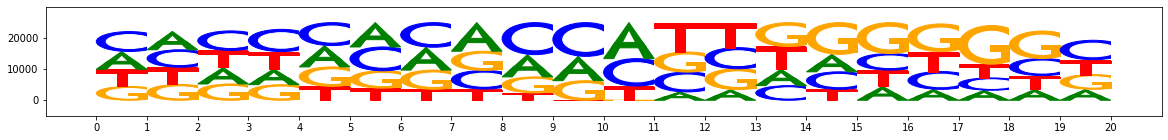

Merged seqlet sequences (scaled by information content)


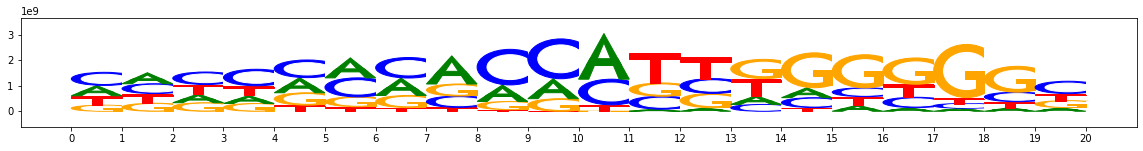

Cluster 1:



Merged seqlet sequences


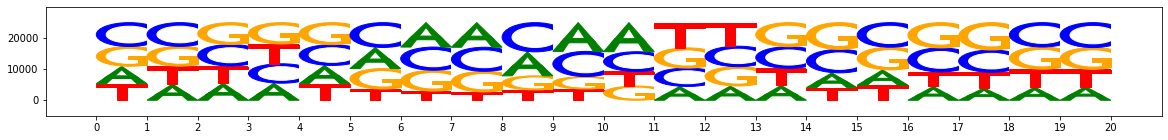

Merged seqlet sequences (scaled by information content)


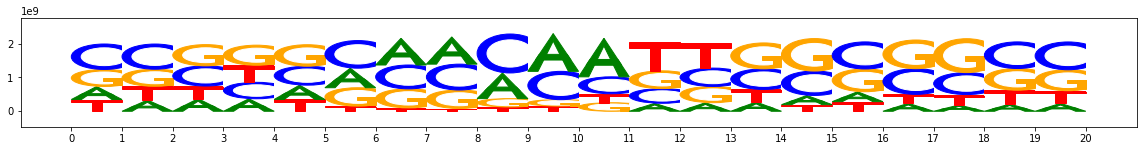

Cluster 2:



Merged seqlet sequences


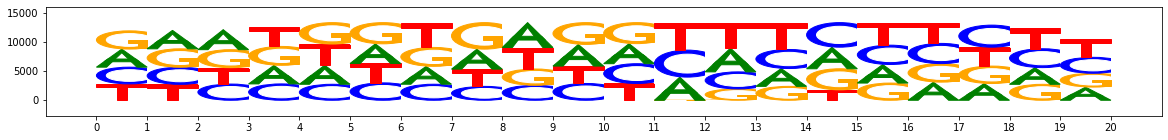

Merged seqlet sequences (scaled by information content)


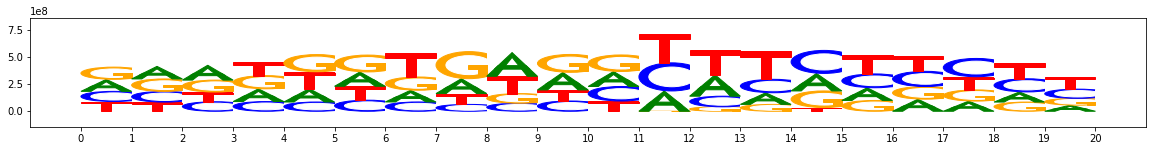

In [44]:
# For each cluster, merge together the seqlets successively to
# construct motifs
for cluster_ind, cluster_id in enumerate(cluster_ids):
    print("Cluster %d:" % cluster_id)
    cluster_mask = cluster_assignments == cluster_ind
#     hyp_motif = aggregate_seqlets(hyp_seqlets[cluster_mask])
#     print("Merged hypothetical seqlets")
#     viz_sequence.plot_weights(hyp_motif)
#     act_motif = aggregate_seqlets(act_seqlets[cluster_mask])
#     print("Merged actual seqlets")
#     viz_sequence.plot_weights(act_motif)
    seq_motif = aggregate_seqlets(seqlet_seqs[cluster_mask])
    print("Merged seqlet sequences")
    viz_sequence.plot_weights(seq_motif)
    ic = pwm_info_content(seq_motif, background)
    seq_pwm = np.expand_dims(ic, axis=0) * seq_motif
    print("Merged seqlet sequences (scaled by information content)")
    viz_sequence.plot_weights(seq_pwm)